In [ ]:
### from Adrian Rosebrock: https://www.pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/

In [109]:
from tensorflow.keras import datasets, layers, models, backend as K

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [149]:
(x, y), (x_t, y_t) = datasets.mnist.load_data()
x = x / 255.0
x_t = x_t / 255.0

x = np.expand_dims(x, axis=-1)
x_t = np.expand_dims(x_t, axis=-1)

In [141]:
def make_pairs(images, labels):
    """Pairs of positive and negative pairs."""
    pairImages = []
    pairLabels = []
    
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    
    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        
        # Randomly pick an image of the same label
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        
        # Add the positive pair
        pairImages.append([currentImage, posImage])
        pairLabels.append([1]) # 1, as they are similar (true)
       
        # Randomly select negative image (different label)
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        
        # Add the negative pair
        pairImages.append([currentImage, negImage])
        pairLabels.append([0]) # 0, as they are different (false)
        
    return np.asarray(pairImages), np.array(pairLabels)        

In [150]:
pair_train, label_train = make_pairs(x, y)
pair_test, label_test = make_pairs(x_t, y_t)

In [104]:
def build_siamese_model(inputShape, embeddginDim=48):
    # Specify input shape for feature extractore network
    inputs = layers.Input(inputShape)
    
    # CONV => RELU => POOL => DROPOUT layers
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(inputs)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Dropout(.3)(x)
    
    # CONV => RELU => POOL => DROPOUT layers
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Dropout(.3)(x)
    
    # Prepare final outputs
    pooledOutput = layers.GlobalMaxPool2D()(x)
    outputs = layers.Dense(embeddginDim)(pooledOutput)
    
    # Build model
    model = models.Model(inputs, outputs)
    
    return model

In [144]:
def euclidean_distance(vectors):
    # Unpack vectors
    (feats_a, feats_b) = vectors
    
    # Compute sum of squared distance between vectors
    sum_squared = K.sum(K.square(feats_a - feats_b), axis=1, keepdims =True)
    
    # Return euclidean dist. between the vectors
    return K.sqrt(K.maximum(sum_squared, K.epsilon())) 

In [287]:
def plot_training(H, plotpath):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accruacy")
    plt.legend(loc="center right")
    plt.savefig(plotpath)

In [153]:
IMG_SHAPE = (28, 28, 1)
# Configure siamese network
img_a = layers.Input(shape=IMG_SHAPE)
img_b = layers.Input(shape=IMG_SHAPE)
feature_extractor = build_siamese_model(IMG_SHAPE)
feats_a = feature_extractor(img_a)
feats_b = feature_extractor(img_b)

# Construct network
distance = layers.Lambda(euclidean_distance)([feats_a, feats_b])
outputs = layers.Dense(1, activation="sigmoid")(distance)
model = models.Model(inputs=[img_a, img_b], outputs=outputs)

In [161]:
# Compile model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [162]:
# Train
history = model.fit([pair_train[:, 0], pair_train[:, 1]], label_train[:], 
                    validation_data=([pair_test[:, 0], pair_test[:, 1]], label_test[:]),
                    batch_size=32,
                    epochs=10)

Epoch 1/10
3750/3750 [==============================] - 164s 44ms/step - loss: 0.5647 - accuracy: 0.6769 - val_loss: 0.3423 - val_accuracy: 0.8721
Epoch 2/10
3750/3750 [==============================] - 172s 46ms/step - loss: 0.3180 - accuracy: 0.8823 - val_loss: 0.2620 - val_accuracy: 0.8926
Epoch 3/10
3750/3750 [==============================] - 164s 44ms/step - loss: 0.2449 - accuracy: 0.9101 - val_loss: 0.2719 - val_accuracy: 0.8763
Epoch 4/10
3750/3750 [==============================] - 167s 44ms/step - loss: 0.2114 - accuracy: 0.9215 - val_loss: 0.2178 - val_accuracy: 0.9090
Epoch 5/10
3750/3750 [==============================] - 143s 38ms/step - loss: 0.1865 - accuracy: 0.9297 - val_loss: 0.2436 - val_accuracy: 0.8878
Epoch 6/10
3750/3750 [==============================] - 151s 40ms/step - loss: 0.1732 - accuracy: 0.9347 - val_loss: 0.2316 - val_accuracy: 0.8960
Epoch 7/10
3750/3750 [==============================] - 157s 42ms/step - loss: 0.1638 - accuracy: 0.9381 - val_loss: 0

In [277]:
threshold = .9 # better than .5
predictions = model.predict([pair_test[:, 0], pair_test[:, 1]])
positive_pairs_score = [1 if predictions[i] >= threshold else 0 for i in range(0, len(predictions), 2)]
negative_pairs_score = [1 if predictions[i] <= threshold else 0 for i in range(1, len(predictions), 2)]

accuraccy = (np.sum(positive_pairs_score) + np.sum(negative_pairs_score)) / len(predictions)
print(accuraccy)

0.9685


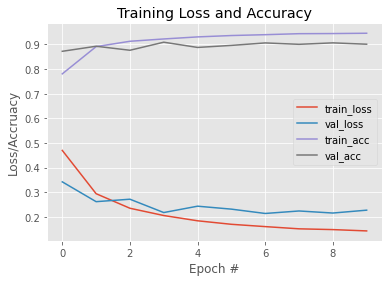

In [288]:
plot_training(history, 'siamese_s_verification_traning')